In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import os
import tensorflow as tf

from pathlib import Path

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../../coco_persons/'
TEST_PATH = '../../PennFudanPed/TEST/'
MASK_PATH  = 'masks'

IMAGE_PATH = 'images'
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed



Using TensorFlow backend.


In [9]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [2]:
train_img_ids = next(os.walk(TRAIN_PATH + IMAGE_PATH))[2]

train_mask_ids = next(os.walk(TRAIN_PATH + MASK_PATH))[2]

test_img_ids = next(os.walk(TEST_PATH + 'PNGImages'))[2]

# Get and resize train images and masks
X_train = np.zeros((len(train_img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_img_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

for n, id_ in tqdm_notebook(enumerate(train_img_ids), total=len(train_img_ids)):
    path = TRAIN_PATH + IMAGE_PATH + "/"
    path_masks = TRAIN_PATH + MASK_PATH + "/"
    if Path(path+id_).exists and Path(path_masks + id_).exists:
        try:
            img = imread(path+id_)[:,::IMG_CHANNELS]
        except IndexError as e:
            print(e)
            if Path(path+id_).exists:
                os.remove(path+id_)

            if Path(path_masks + id_).exists:    
                os.remove(path_masks+id_)
            continue

        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        try:
            X_train[n] = img
        except ValueError as v:
            print(v)
            if Path(path+id_).exists:
                os.remove(path+id_)
            if Path(path_masks + id_).exists: 
                os.remove(path_masks+id_)
            continue
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)



        path = TRAIN_PATH + MASK_PATH + "/"
        mask_ = imread(path+id_[:-4]+'.png')

        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
        #print(np.unique(mask))
        mask = np.where(mask<0.0001, 0, 1)
        Y_train[n] = mask

Getting and resizing train images and masks ... 


In [3]:
# Get and resize test images
X_test = np.zeros((len(test_img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print(len(test_img_ids))
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_img_ids), total=len(test_img_ids)):
    path = TEST_PATH + 'PNGImages' + '/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

16
Getting and resizing test images ... 


100%|██████████| 16/16 [00:00<00:00, 104.96it/s]

Done!


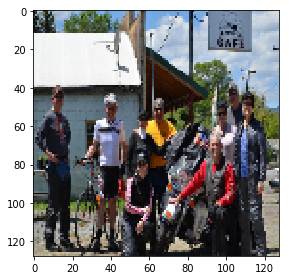

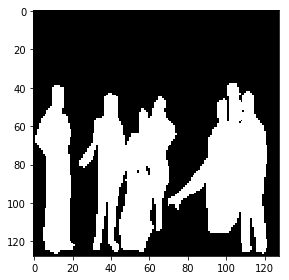

In [8]:
# Check if training data looks all right
ix = random.randint(0, len(train_img_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [15]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c1") (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c2") (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c3") (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c4") (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c5") (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name="u6") (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c6") (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c7") (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name="u8") (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c8") (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', name="u9") (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same', name="c9") (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 128, 128, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 128, 128, 16) 448         lambda_4[0][0]                   
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 128, 128, 16) 0           conv2d_56[0][0]                  
__________________________________________________________________________________________________
c1 (Conv2D

In [16]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [18]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('../../modele/unet_on_coco.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 57541 samples, validate on 6394 samples
Epoch 1/50
57541/57541 [==============================] - 122s 2ms/step - loss: 0.2951 - mean_iou: 0.4606 - val_loss: 0.2780 - val_mean_iou: 0.5056

Epoch 00001: val_loss improved from inf to 0.27796, saving model to ../../modele/unet_on_coco.h5
Epoch 2/50
57541/57541 [==============================] - 122s 2ms/step - loss: 0.2336 - mean_iou: 0.5319 - val_loss: 0.2124 - val_mean_iou: 0.5506

Epoch 00002: val_loss improved from 0.27796 to 0.21237, saving model to ../../modele/unet_on_coco.h5
Epoch 3/50
57541/57541 [==============================] - 122s 2ms/step - loss: 0.2105 - mean_iou: 0.5649 - val_loss: 0.1916 - val_mean_iou: 0.5781

Epoch 00003: val_loss improved from 0.21237 to 0.19158, saving model to ../../modele/unet_on_coco.h5
Epoch 4/50
57541/57541 [==============================] - 121s 2ms/step - loss: 0.1970 - mean_iou: 0.5887 - val_loss: 0.1874 - val_mean_iou: 0.5978

Epoch 00004: val_loss improved from 0.19158 to 0.18744, 

In [19]:


# Predict on train, val and test
model = load_model('../../modele/unet_on_coco.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 

SyntaxError: unexpected EOF while parsing (<ipython-input-19-16afc0f92081>, line 18)

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [ ]:
# Perform a sanity check on some random validation samples
print(len(preds_test_t))
ix = random.randint(0, len(preds_test_t)-1)
print(X_train.shape[0])
print(X_test.shape[0])
print(int(X_test.shape[0]*0.9))
print(ix)
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()